In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d, medfilt
from scipy.stats import linregress

from skimage.morphology import skeletonize
from skimage.filters import sobel
from skimage import feature

In [117]:
def find_endpoints(img):
    # Kernel to sum the neighbours
    kernel = [[1, 1, 1],
              [1, 0, 1],
              [1, 1, 1]]
   
    # 2D convolution (cast image to int32 to avoid overflow)
    img_conv = convolve2d(img.astype(np.int32), kernel, mode='same')
    
    # Pick points where pixel is 255 and neighbours sum 255
    endpoints = np.stack(np.where((img == 255) & (img_conv == 255)), axis=1)
    
    return endpoints


def extend_skeleton(skeleton, outline, sobel, line_end):
    
    local_skeleton = skeleton.copy()
    end_x = line_end[1]
    end_y = line_end[0]
    
    # Find indices where the value is 1
    indices = np.argwhere(skeleton == 255)

    # Calculate the gradient at both ends of the line
    loc = np.where(np.all(indices == [end_y, end_x], axis=1))[0][0]
    
    if loc < 10:        
        previous_end_y = list(indices[loc:loc+5, 0])
        previous_end_x = list(indices[loc:loc+5, 1])
    else:
        previous_end_y = list(indices[loc-5:loc, 0])
        previous_end_x = list(indices[loc-5: loc, 1])
    
    while True:
        end_pixel = outline[end_y, end_x]
        
        # If the end pixel is on the outline the skeleton extension process is finished
        if end_pixel == 255:
            break
            
        # If the end pixel is not on the outline we need to find the nearest pixel (out of the neighbouring pixels that are the best to extend along)
        # Note we need to exclude the current skeleton from this
        
        # Get sobel neighbours and skel neigbours
        sobel_neighbours = sobel[end_y-1:end_y+2, end_x-1:end_x+2]
        skeleton_neighbours = np.invert(local_skeleton[end_y-1:end_y+2, end_x-1:end_x+2])
                
        # Filter out skel neighbours if present
        
        possible_routes = np.divide(skeleton_neighbours * sobel_neighbours, 255)
        
        if possible_routes.size == 0:
            break
            
        try:
            current_gradient = linregress(previous_end_x, previous_end_y)
            slope = current_gradient.slope
            if slope > 0:
                possible_routes[0][0] = 0
                possible_routes[1][0] = 0
                possible_routes[2][1] = 0
                possible_routes[2][2] = 0
            elif slope < 0:
                possible_routes[2][0] = 0
                possible_routes[1][0] = 0
                possible_routes[0][1] = 0
                possible_routes[0][2] = 0
            else:
                possible_routes[0][0] = 0
                possible_routes[0][1] = 0
                possible_routes[0][2] = 0
                possible_routes[2][0] = 0
                possible_routes[2][1] = 0
                possible_routes[2][2] = 0
        except:
            pass

        possible_routes[possible_routes==0] = 'nan'
        
        # Select best sobel neighbour
        rel_cords = np.where(possible_routes == np.nanmin(possible_routes))
        
        if len(rel_cords[0]) == 0:
            break
        
        coord_translation = [rel_cords[0][0] -1, rel_cords[1][0] -1]
        
        # New end of line coord
        end_y = end_y + coord_translation[0]
        end_x = end_x + coord_translation[1]
        
        #Update local skel
        local_skeleton[end_y, end_x] = 255
        
        # Add to queue
        if(len(previous_end_x) > 100):
            previous_end_x.pop(0)
            previous_end_y.pop(0)
        
        previous_end_x.append(end_x)
        previous_end_y.append(end_y)
        
    return local_skeleton


def get_skeleton(image, smoothen=False):
    
    
    if smoothen:
        # Smoothed image
        smoothened_image = medfilt(image, kernel_size=25)
        skeleton = skeletonize(smoothened_image)
    else:
        skeleton = skeletonize(image)
    
    skeleton_im = skeleton * np.uint8(255)

    # Get outline + smooth image
    #outline = cv2.Canny(image, 0,0)
    outline = feature.canny(image.astype('float')) * np.uint8(255)

    edt = distance_transform_edt(image) 
    sobel_edt = sobel(edt)

    # Work out inital end of skeleton
    end_points = find_endpoints(skeleton_im)

    extended_skeleton = skeleton_im.copy()

    for end_point in end_points:
        extended_skeleton = extend_skeleton(extended_skeleton, outline, sobel_edt, end_point)
        
    return extended_skeleton, outline

def get_widths(image, extended_skeleton):

    widths = distance_transform_edt(image)
    skeleton_only_width = np.multiply(np.divide(widths * extended_skeleton, 255), 2)    
    skeleton_only_width[skeleton_only_width<1] = 'nan'
    
    skel_length = np.multiply(np.divide(widths * extended_skeleton, 255), 2)
    skel_length[skel_length==0] = 'nan'
    skel_length = len(skel_length[~np.isnan(skel_length)])
    
    adjusted_measurements = skeleton_only_width[~np.isnan(skeleton_only_width)]
    
    try:
        min_width = np.min(adjusted_measurements)
        max_width = np.max(adjusted_measurements)
    except:
        min_width = np.nan
        max_width = np.nan
        
    return adjusted_measurements, min_width, max_width


In [118]:
def plot_skeleton(full_image, object_no, smoothen=False):
    obj_image = np.uint8((full_image==object_no).astype(int))
    extended_skeleton, outline = get_skeleton(obj_image, smoothen)

    
    plt.imshow(extended_skeleton)
    plt.imshow(outline, alpha=0.4)

In [119]:
from skimage import io

In [120]:
full_image = io.imread('TestData/Plate1-TreatmentC-Well3-Area2-StainMYHC_cp_masks.png')

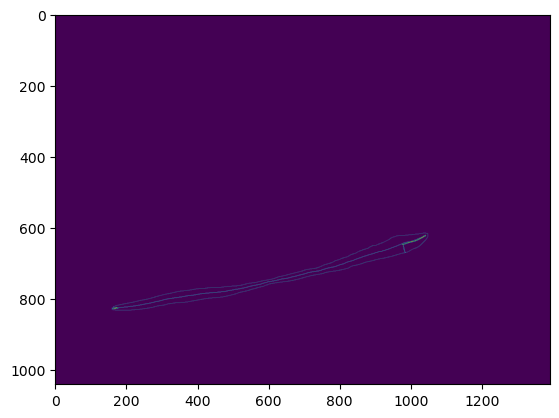

In [123]:
plot_skeleton(full_image,18, smoothen=False)